In [74]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Math

from qiskit.circuit import Gate
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [75]:
np.random.seed(0)

In [76]:
# the code is [[4, 2, 2]]
# we encode 2 logical qubits into 4 physical qubits

Hx = np.array([
    [1, 1, 1, 1]
], dtype=int)

Hz = np.array([
    [1, 1, 1, 1]
], dtype=int)

Lx = np.array([[1, 1, 0, 0], [1, 0, 1, 0]], dtype=int)
Lz = np.array([[0, 1, 0, 1], [0, 0, 1, 1]], dtype=int)

print(f"We have {Hx.shape[1]} data qubits")
print(f"We have {Hx.shape[0]} X-Stabilizers")
print(f"We have {Hz.shape[0]} Z-Stabilizers")
print(f"We have {Hx.shape[1] + Hx.shape[0] + Hz.shape[0]} physical qubits")
print(f"We have {Lx.shape[0]} logical qubits")


We have 4 data qubits
We have 1 X-Stabilizers
We have 1 Z-Stabilizers
We have 6 physical qubits
We have 2 logical qubits


In [77]:
orthogonality = (Hx @ Hz.T) % 2
display(Math(r'\text{Orthogonality test: } H_X \cdot H_Z^T \text{ mod 2 gave:}'))
print(orthogonality)

<IPython.core.display.Math object>

[[0]]


In [78]:
anticommutation = (Lx @ Lz.T) % 2
display(Math(r'\text{Check } L_X L_Z^T \bmod 2 \text{ (should be } I_k\text{):}'))
print(anticommutation)

<IPython.core.display.Math object>

[[1 0]
 [0 1]]


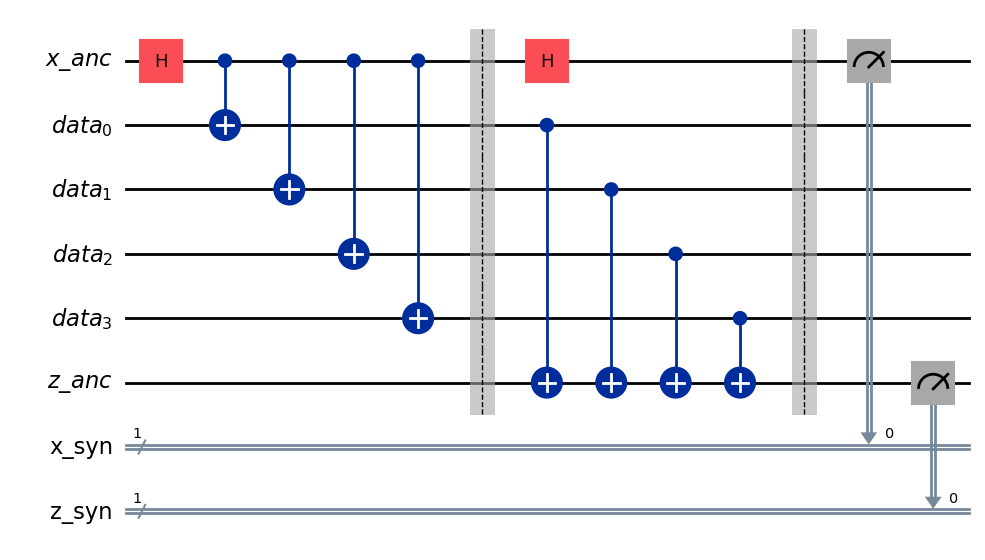

In [79]:
data = QuantumRegister(4, 'data')
x_ancillas = QuantumRegister(1, 'x_anc')
z_ancillas = QuantumRegister(1, 'z_anc')

x_meas = ClassicalRegister(1, 'x_syn')
z_meas = ClassicalRegister(1, 'z_syn')

qc = QuantumCircuit(x_ancillas, data, z_ancillas, x_meas, z_meas)

qc.h(x_ancillas)

qc.cx(x_ancillas, data[0])
qc.cx(x_ancillas, data[1])
qc.cx(x_ancillas, data[2])
qc.cx(x_ancillas, data[3])

qc.barrier()

qc.cx(data[0], z_ancillas)
qc.cx(data[1], z_ancillas)
qc.cx(data[2], z_ancillas)
qc.cx(data[3], z_ancillas)

qc.h(x_ancillas)

qc.barrier()

qc.measure(x_ancillas, x_meas)
qc.measure(z_ancillas,z_meas)

circuit_drawer(qc, output="mpl")

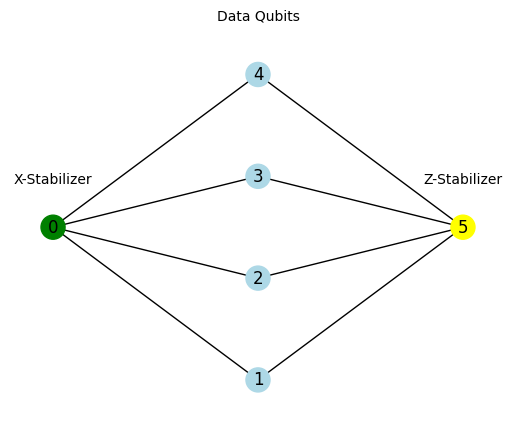

In [80]:
G = nx.Graph()

G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 3)
G.add_edge(0, 4)

G.add_edge(1, 5)
G.add_edge(2, 5)
G.add_edge(3, 5)
G.add_edge(4, 5)

pos = {
    0: (0, 0), 
    1: (1, -1.5), 
    2: (1, -0.5), 
    3: (1, 0.5), 
    4: (1, 1.5), 
    5: (2, 0), 
}

node_colors = ['green' if node in [0] else 'yellow' if node in [5] else 'lightblue' for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=None)

plt.text(0, 0.4, 'X-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(2, 0.4, 'Z-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(1, 2, 'Data Qubits', ha='center', va='bottom', fontsize=10)

ax = plt.gca()
plt.axis("off")
plt.show()

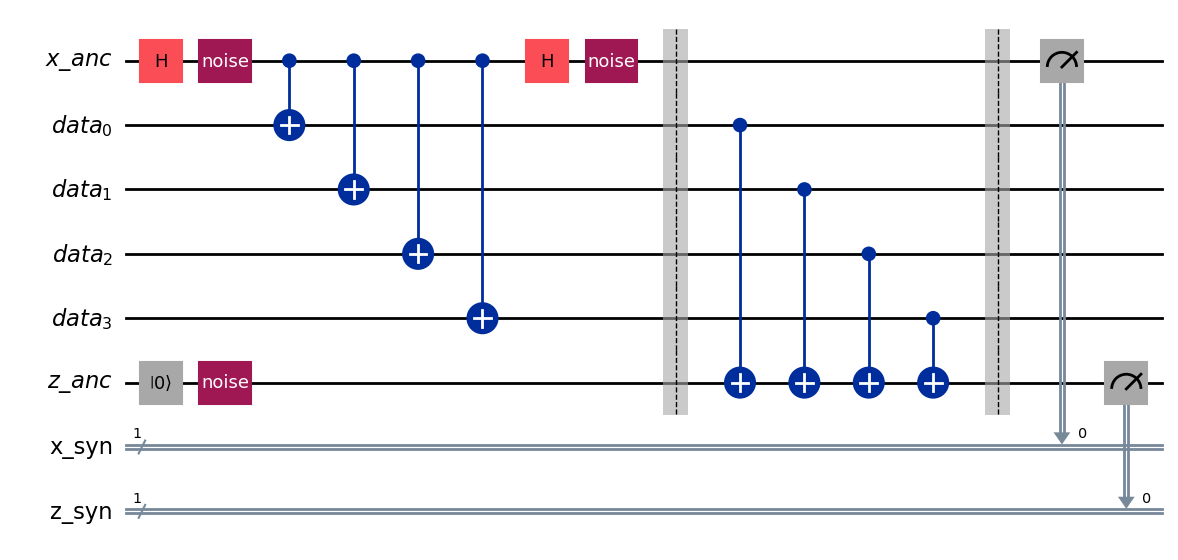

In [81]:
data = QuantumRegister(4, 'data')
x_ancillas = QuantumRegister(1, 'x_anc')
z_ancillas = QuantumRegister(1, 'z_anc')

x_meas = ClassicalRegister(1, 'x_syn')
z_meas = ClassicalRegister(1, 'z_syn')

noise_gate = Gate('noise', 1, [])
idle_gate = Gate('idle', 1, [])

qc = QuantumCircuit(x_ancillas, data, z_ancillas, x_meas, z_meas)

qc.h(x_ancillas)
qc.append(noise_gate, x_ancillas)
qc.reset(z_ancillas)
qc.append(noise_gate, z_ancillas)

for i in range(4):
    qc.cx(x_ancillas, data[i])

qc.h(x_ancillas)
qc.append(noise_gate, x_ancillas)

qc.barrier()

for i in range(4):
    qc.cx(data[i], z_ancillas)

qc.barrier()

qc.measure(x_ancillas, x_meas)
qc.measure(z_ancillas, z_meas)

circuit_drawer(qc, output="mpl")

### Differences from Code-Capacity Model

| Aspect | Code-Capacity | Circuit-Level |
|--------|---------------|---------------|
| **Syndrome** | $m$ bits (one per check) | $m \times T$ bits (check × time) |
| **Matrix columns** | Physical qubits | **Fault equivalence classes** |
| **Matrix construction** | From code definition | **From simulation** |
| **Decoding finds** | Which qubits have errors | **Logical effect of faults** |

## Circuit Representation

We represent the circuit as a list of tuples. Each operation is:
- `('PrepX', qubit)` - Prepare in |+⟩ state
- `('PrepZ', qubit)` - Prepare in |0⟩ state  
- `('CNOT', control, target)` - CNOT gate
- `('MeasX', qubit)` - Measure in X-basis
- `('MeasZ', qubit)` - Measure in Z-basis
- `('IDLE', qubit)` - Qubit idles

In [82]:
def build_circuit_single_cycle():
    
    cycle = []
    
    cycle.append(('PrepX', ('Xcheck', 0)))
    cycle.append(('PrepZ', ('Zcheck', 0)))
    
    for i in range(4):
        cycle.append(('CNOT', ('Xcheck', 0), ('data', i)))
    
    for i in range(4):
        cycle.append(('CNOT', ('data', i), ('Zcheck', 0)))
    
    cycle.append(('MeasX', ('Xcheck', 0)))
    cycle.append(('MeasZ', ('Zcheck', 0)))
    
    return cycle

NUM_CYCLES = 2
single_cycle = build_circuit_single_cycle()
full_circuit = single_cycle * NUM_CYCLES

print(f"Single cycle has {len(single_cycle)} operations:")
for i, op in enumerate(single_cycle):
    print(f"  {i}: {op}")
    
print(f"\nFull circuit: {NUM_CYCLES} cycles × {len(single_cycle)} ops = {len(full_circuit)} operations")

Single cycle has 12 operations:
  0: ('PrepX', ('Xcheck', 0))
  1: ('PrepZ', ('Zcheck', 0))
  2: ('CNOT', ('Xcheck', 0), ('data', 0))
  3: ('CNOT', ('Xcheck', 0), ('data', 1))
  4: ('CNOT', ('Xcheck', 0), ('data', 2))
  5: ('CNOT', ('Xcheck', 0), ('data', 3))
  6: ('CNOT', ('data', 0), ('Zcheck', 0))
  7: ('CNOT', ('data', 1), ('Zcheck', 0))
  8: ('CNOT', ('data', 2), ('Zcheck', 0))
  9: ('CNOT', ('data', 3), ('Zcheck', 0))
  10: ('MeasX', ('Xcheck', 0))
  11: ('MeasZ', ('Zcheck', 0))

Full circuit: 2 cycles × 12 ops = 24 operations


In [83]:
def build_qubit_mapping():
    lin_order = {}
    idx = 0
    
    Xchecks = [('Xcheck', 0)]
    for q in Xchecks:
        lin_order[q] = idx
        idx += 1
    
    Zchecks = [('Zcheck', 0)]
    for q in Zchecks:
        lin_order[q] = idx
        idx += 1
    
    data_qubits = [('data', i) for i in range(4)]
    for q in data_qubits:
        lin_order[q] = idx
        idx += 1
    
    return lin_order, Xchecks, Zchecks, data_qubits

lin_order, Xchecks, Zchecks, data_qubits = build_qubit_mapping()

## Propagation Simulation

The key insight of circuit-level noise simulation is that **Z and X errors propagate independently**.

### Z-Error Propagation Rules:
- **CNOT**: Z on target → Z on both (propagates to control via phase kickback)
- **PrepX**: Resets Z error to 0 (projects to X eigenstate)
- **MeasX**: Z error flips the measurement outcome

### X-Error Propagation Rules:
- **CNOT**: X on control → X on both (propagates to target)
- **PrepZ**: Resets X error to 0 (projects to Z eigenstate)
- **MeasZ**: X error flips the measurement outcome

In [84]:
def simulate_circuit_Z(circuit, lin_order, Xchecks):

    total_qubits = len(lin_order)
    state = np.zeros(total_qubits, dtype=int)
    
    syndrome_history = []
    syndrome_map = {c: [] for c in Xchecks}
    syn_idx = 0
    
    for gate in circuit:
        gate_type = gate[0]
        
        if gate_type == 'CNOT':
            ctrl_idx = lin_order[gate[1]]
            tgt_idx = lin_order[gate[2]]
            
            state[ctrl_idx] = (state[ctrl_idx] + state[tgt_idx]) % 2
            
        elif gate_type == 'PrepX':
            q_idx = lin_order[gate[1]]
            state[q_idx] = 0
            
        elif gate_type == 'MeasX':
            q_idx = lin_order[gate[1]]
            check_label = gate[1]
            syndrome_history.append(state[q_idx])
            syndrome_map[check_label].append(syn_idx)
            syn_idx += 1
            
        elif gate_type in ['Z', 'Y']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['ZZ', 'YY', 'YZ', 'ZY']:
            q1_idx = lin_order[gate[1]]
            q2_idx = lin_order[gate[2]]
            state[q1_idx] = (state[q1_idx] + 1) % 2
            state[q2_idx] = (state[q2_idx] + 1) % 2
            
        elif gate_type in ['ZX', 'YX']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['XZ', 'XY']:
            q_idx = lin_order[gate[2]]
            state[q_idx] = (state[q_idx] + 1) % 2
    
    return np.array(syndrome_history), state, syndrome_map


def simulate_circuit_X(circuit, lin_order, Zchecks):
    total_qubits = len(lin_order)
    state = np.zeros(total_qubits, dtype=int)
    
    syndrome_history = []
    syndrome_map = {c: [] for c in Zchecks}
    syn_idx = 0
    
    for gate in circuit:
        gate_type = gate[0]
        
        if gate_type == 'CNOT':
            ctrl_idx = lin_order[gate[1]]
            tgt_idx = lin_order[gate[2]]
            state[tgt_idx] = (state[tgt_idx] + state[ctrl_idx]) % 2
            
        elif gate_type == 'PrepZ':
            q_idx = lin_order[gate[1]]
            state[q_idx] = 0
            
        elif gate_type == 'MeasZ':
            q_idx = lin_order[gate[1]]
            check_label = gate[1]
            syndrome_history.append(state[q_idx])
            syndrome_map[check_label].append(syn_idx)
            syn_idx += 1
            
        elif gate_type in ['X', 'Y']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['XX', 'YY', 'XY', 'YX']:
            q1_idx = lin_order[gate[1]]
            q2_idx = lin_order[gate[2]]
            state[q1_idx] = (state[q1_idx] + 1) % 2
            state[q2_idx] = (state[q2_idx] + 1) % 2
            
        elif gate_type in ['XZ', 'YZ']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['ZX', 'ZY']:
            q_idx = lin_order[gate[2]]
            state[q_idx] = (state[q_idx] + 1) % 2
    
    return np.array(syndrome_history), state, syndrome_map

## Syndrome Sparsification

Raw syndromes have a problem: a single error can flip **all subsequent measurements** of a check. This makes decoding harder because errors "persist" in the syndrome.

**Sparsification** computes the XOR of consecutive measurements:
$$\text{sparse}[t] = \text{raw}[t] \oplus \text{raw}[t-1]$$

This gives us **1** only at timesteps where the syndrome **changed**.

```
Check C₀ across 4 cycles:
  Cycle:    1    2    3    4
  Raw:      0    0    1    1    ← Error occurred before cycle 3
  Sparse:   0    0    1    0    ← Only cycle 3 shows change!
```


Since, we do not fix error until the end of all the cycles, we need a proper way to manage the spatio-temporal decoing. Imagine this 2 case:
- The error is in a data qubit
- The error is a measurement error


**First case**: the raw syndrome will look something like this: `0 0 1 1` and the sparsified syndrome like this `0 0 1 0`. We can clearly see that the data qubit error was at the third cycle.


**Second case**: the raw syndrome will look something like this `0 0 1 0` and the sparsified syndrome like this `0 0 1 1`. We can distinguish the 2 cases!

A single data qubit error will make decoding impossible for the subsequent cycles!

In [85]:
def sparsify_syndrome(syndrome_history, syndrome_map, checks):
    result = syndrome_history.copy()
    
    for check in checks:
        positions = syndrome_map[check]
        
        for i in range(1, len(positions)):
            prev_idx = positions[i - 1]
            curr_idx = positions[i]
            result[curr_idx] = (result[curr_idx] + syndrome_history[prev_idx]) % 2
    
    return result

print("=== Sparsification Demonstration ===\n")

demo_circuit = full_circuit.copy()

error_position = 2 * len(single_cycle) + 3
demo_circuit_with_error = demo_circuit[:error_position] + [('Z', ('data', 0))] + demo_circuit[error_position:]

raw_syndrome, final_state, syn_map = simulate_circuit_Z(demo_circuit_with_error, lin_order, Xchecks)
sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Xchecks)

print(f"Error injected at position {error_position} (cycle 3)")
print(f"\nRaw X-syndrome (across {NUM_CYCLES} cycles):")
print(f"  {raw_syndrome}")
print(f"\nSparsified X-syndrome:")
print(f"  {sparse_syndrome}")
print(f"\nNon-zero positions in raw:    {np.nonzero(raw_syndrome)[0]}")
print(f"Non-zero positions in sparse: {np.nonzero(sparse_syndrome)[0]}")

=== Sparsification Demonstration ===

Error injected at position 27 (cycle 3)

Raw X-syndrome (across 2 cycles):
  [0 0]

Sparsified X-syndrome:
  [0 0]

Non-zero positions in raw:    []
Non-zero positions in sparse: []


## The Depolarizing Noise Model

In circuit-level noise, errors can occur at multiple locations:

| Location | Error Type | Probability | Syndrome Affected |
|----------|-----------|-------------|-------------------|
| **MeasX** | Z before measurement | $p$ | X-check |
| **MeasZ** | X before measurement | $p$ | Z-check |
| **PrepX** | Z after preparation | $p$ | X-check |
| **PrepZ** | X after preparation | $p$ | Z-check |
| **IDLE** | X, Y, or Z (1/3 each) | $p$ | Both (Y = XZ) |
| **CNOT** | One of 15 two-qubit Paulis | $p$ | Both |

### CNOT Error Details
After a CNOT, one of 15 equally likely two-qubit Paulis can occur:
- 3 on control only: X⊗I, Y⊗I, Z⊗I  
- 3 on target only: I⊗X, I⊗Y, I⊗Z
- 9 correlated: XX, XY, XZ, YX, YY, YZ, ZX, ZY, ZZ

The probability that a fault has a Z-component on a specific qubit is $\frac{4}{15}p$ (4 out of 15 Paulis have Z on each position).

In [86]:
def _gate_qubits(gate):
    """Return the set of qubits acted on by an ideal operation tuple."""
    gate_type = gate[0]
    if gate_type in ['PrepX', 'PrepZ', 'MeasX', 'MeasZ', 'IDLE']:
        return {gate[1]}
    if gate_type == 'CNOT':
        return {gate[1], gate[2]}
    return set()


def generate_noisy_circuit(circuit, error_rate, all_qubits):
    """
    Circuit-level depolarizing model (toy):
    - Add gate-associated faults (as before)
    - PLUS: for each timestep, all other qubits are treated as implicitly idle and can suffer memory noise.
    """
    noisy = []
    all_qubits = list(all_qubits)
    
    for gate in circuit:
        gate_type = gate[0]
        acted = _gate_qubits(gate)
        idle_qubits = [q for q in all_qubits if q not in acted]
        
        if gate_type == 'MeasX':
            # Z before X-measurement flips the outcome
            if np.random.random() < error_rate:
                noisy.append(('Z', gate[1]))
            noisy.append(gate)
            
        elif gate_type == 'MeasZ':
            # X before Z-measurement flips the outcome
            if np.random.random() < error_rate:
                noisy.append(('X', gate[1]))
            noisy.append(gate)
            
        elif gate_type == 'PrepX':
            noisy.append(gate)
            # Z after PrepX corrupts the prepared |+>
            if np.random.random() < error_rate:
                noisy.append(('Z', gate[1]))
                
        elif gate_type == 'PrepZ':
            noisy.append(gate)
            # X after PrepZ corrupts the prepared |0>
            if np.random.random() < error_rate:
                noisy.append(('X', gate[1]))
                
        elif gate_type == 'IDLE':
            # Explicit idle (kept for completeness)
            noisy.append(gate)
            if np.random.random() < error_rate:
                pauli = np.random.choice(['X', 'Y', 'Z'])
                noisy.append((pauli, gate[1]))
        
        elif gate_type == 'CNOT':
            noisy.append(gate)
            # After CNOT, one of 15 non-identity 2-qubit Paulis
            if np.random.random() < error_rate:
                err_idx = np.random.randint(15)
                control, target = gate[1], gate[2]
                
                if err_idx < 3:
                    pauli = ['X', 'Y', 'Z'][err_idx]
                    noisy.append((pauli, control))
                elif err_idx < 6:
                    pauli = ['X', 'Y', 'Z'][err_idx - 3]
                    noisy.append((pauli, target))
                else:
                    correlated = ['XX', 'YY', 'ZZ', 'XY', 'YX', 'YZ', 'ZY', 'XZ', 'ZX']
                    pauli = correlated[err_idx - 6]
                    noisy.append((pauli, control, target))
        else:
            noisy.append(gate)
        
        # Implicit idle memory noise for qubits not acted on in this timestep
        for q in idle_qubits:
            if np.random.random() < error_rate:
                pauli = np.random.choice(['X', 'Y', 'Z'])
                noisy.append((pauli, q))
            
    return noisy

## Building the Decoding Matrix

This is the **most important part**. The decoding matrix $H_{\text{dec}}$ is built by:

1. **Enumerate all possible single faults** in the circuit
2. **Simulate each fault** to get its syndrome pattern + logical effect
3. **Group faults with identical (syndrome, logical)** into equivalence classes
4. **Each equivalence class becomes one column** of $H_{\text{dec}}$
5. **Sum probabilities** of faults in each class to get channel probabilities

### Why This Works

We can't distinguish faults that produce the same syndrome and logical effect. So we treat them as one "super-fault" with summed probability.

### Structure of the Full Matrix

```
                  Fault Equivalence Classes
                  ┌───────────────────────┐
                  │ F₀  F₁  F₂  ...  F_N  │
              ┌───┼───────────────────────┤
  (Check,t=1) │   │  1   0   1   ...   0  │  ← Syndrome part
  (Check,t=2) │ H │  0   1   0   ...   1  │
      ...     │dec│  .   .   .   ...   .  │
  (Check,t=T) │   │  0   1   1   ...   0  │
              ├───┼───────────────────────┤
      L₀      │   │  1   0   0   ...   1  │  ← Logical effect part
      L₁      │   │  0   1   0   ...   0  │
              └───┴───────────────────────┘
```

The last $k$ rows encode the **logical effect** of each fault class.

The logical effect is computed this way: `logical_effect = (Lz @ data_state) % 2` and `data_state` it's the net error remaining after the error propagation

In [87]:
def enumerate_faults_Z(circuit, error_rate, all_qubits):
    """
    Enumerate single-fault Z-type locations (i.e., faults with a Z component) that affect X-check syndromes.
    Includes both gate-associated faults and implicit-idle memory faults at every timestep.
    """
    fault_specs = []
    fault_probs = []
    
    for pos, gate in enumerate(circuit):
        gate_type = gate[0]
        acted = _gate_qubits(gate)
        idle_qubits = [q for q in all_qubits if q not in acted]
        
        # Gate-associated faults
        if gate_type == 'MeasX':
            fault_specs.append((pos, ('Z', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'PrepX':
            fault_specs.append((pos + 1, ('Z', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'IDLE':
            fault_specs.append((pos + 1, ('Z', gate[1])))
            fault_probs.append(error_rate * 2/3)
            
        elif gate_type == 'CNOT':
            control, target = gate[1], gate[2]
            for err in [('Z', control), ('Z', target), ('ZZ', control, target)]:
                fault_specs.append((pos + 1, err))
                fault_probs.append(error_rate * 4/15)
        
        # Implicit idle memory faults (Z component occurs for Z or Y => prob 2/3 * p)
        for q in idle_qubits:
            fault_specs.append((pos + 1, ('Z', q)))
            fault_probs.append(error_rate * 2/3)
                
    return fault_specs, fault_probs


def enumerate_faults_X(circuit, error_rate, all_qubits):
    """
    Enumerate single-fault X-type locations (i.e., faults with an X component) that affect Z-check syndromes.
    Includes both gate-associated faults and implicit-idle memory faults at every timestep.
    """
    fault_specs = []
    fault_probs = []
    all_qubits = list(all_qubits)
    
    for pos, gate in enumerate(circuit):
        gate_type = gate[0]
        acted = _gate_qubits(gate)
        idle_qubits = [q for q in all_qubits if q not in acted]
        
        # Gate-associated faults
        if gate_type == 'MeasZ':
            fault_specs.append((pos, ('X', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'PrepZ':
            fault_specs.append((pos + 1, ('X', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'IDLE':
            fault_specs.append((pos + 1, ('X', gate[1])))
            fault_probs.append(error_rate * 2/3)
            
        elif gate_type == 'CNOT':
            control, target = gate[1], gate[2]
            for err in [('X', control), ('X', target), ('XX', control, target)]:
                fault_specs.append((pos + 1, err))
                fault_probs.append(error_rate * 4/15)
        
        # Implicit idle memory faults (X component occurs for X or Y => prob 2/3 * p)
        for q in idle_qubits:
            fault_specs.append((pos + 1, ('X', q)))
            fault_probs.append(error_rate * 2/3)
                
    return fault_specs, fault_probs


ERROR_RATE = 0.005
all_qubits = list(lin_order.keys())
fault_specs_Z, fault_probs_Z = enumerate_faults_Z(full_circuit, ERROR_RATE, all_qubits)
fault_specs_X, fault_probs_X = enumerate_faults_X(full_circuit, ERROR_RATE, all_qubits)

print(f"Fault Enumeration")
print(f"Z-type faults (affect X-checks): {len(fault_specs_Z)}")
print(f"X-type faults (affect Z-checks): {len(fault_specs_X)}")
print(f"\nFirst 10 Z-type faults:")
for i in range(min(10, len(fault_specs_Z))):
    pos, err = fault_specs_Z[i]
    prob = fault_probs_Z[i]
    print(f"  {i}: Position {pos}, Error {err}, Prob {prob:.6f}")

Fault Enumeration
Z-type faults (affect X-checks): 156
X-type faults (affect Z-checks): 156

First 10 Z-type faults:
  0: Position 1, Error ('Z', ('Xcheck', 0)), Prob 0.005000
  1: Position 1, Error ('Z', ('Zcheck', 0)), Prob 0.003333
  2: Position 1, Error ('Z', ('data', 0)), Prob 0.003333
  3: Position 1, Error ('Z', ('data', 1)), Prob 0.003333
  4: Position 1, Error ('Z', ('data', 2)), Prob 0.003333
  5: Position 1, Error ('Z', ('data', 3)), Prob 0.003333
  6: Position 2, Error ('Z', ('Xcheck', 0)), Prob 0.003333
  7: Position 2, Error ('Z', ('data', 0)), Prob 0.003333
  8: Position 2, Error ('Z', ('data', 1)), Prob 0.003333
  9: Position 2, Error ('Z', ('data', 2)), Prob 0.003333


In [88]:
def extract_data_state(state, lin_order, data_qubits):
    return np.array([state[lin_order[q]] for q in data_qubits])

def build_decoding_matrix_Z(circuit, fault_specs, fault_probs, lin_order, Xchecks, data_qubits, Lx):
    
    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    num_syndrome_bits = len(Xchecks) * (NUM_CYCLES + SUFFIX_CYCLES)
    k = Lx.shape[0]
    
    equivalence_classes = {}
    
    print(f"Simulating {len(fault_specs)} faults...")
    
    for fault_idx, (pos, error_tuple) in enumerate(fault_specs):
        
        circuit_with_fault = circuit[:pos] + [error_tuple] + circuit[pos:]
        full_circuit_with_fault = circuit_with_fault + noiseless_suffix
        
        raw_syndrome, final_state, syn_map = simulate_circuit_Z(
            full_circuit_with_fault, lin_order, Xchecks
        )
        
        sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Xchecks)

        data_state = extract_data_state(final_state, lin_order, data_qubits)
        logical_effect = (Lx @ data_state) % 2 
        
        augmented = np.concatenate([sparse_syndrome, logical_effect])
        
        signature = tuple(np.nonzero(augmented)[0])
        
        if signature not in equivalence_classes:
            equivalence_classes[signature] = []
        equivalence_classes[signature].append(fault_idx)
    
    print(f"Found {len(equivalence_classes)} equivalence classes (from {len(fault_specs)} faults)")
    
    num_classes = len(equivalence_classes)
    HdecZ = np.zeros((num_syndrome_bits, num_classes), dtype=int)
    HZ_full = np.zeros((num_syndrome_bits + k, num_classes), dtype=int)
    channel_probs = np.zeros(num_classes)
    
    for col_idx, (signature, fault_indices) in enumerate(equivalence_classes.items()):
        for pos in signature:
            HZ_full[pos, col_idx] = 1
            if pos < num_syndrome_bits:
                HdecZ[pos, col_idx] = 1
        
        channel_probs[col_idx] = sum(fault_probs[i] for i in fault_indices)
    
    return HdecZ, HZ_full, channel_probs, num_syndrome_bits

def build_decoding_matrix_X(circuit, fault_specs, fault_probs, lin_order, Zchecks, data_qubits, Lz):
    
    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    num_syndrome_bits = len(Zchecks) * (NUM_CYCLES + SUFFIX_CYCLES)
    k = Lz.shape[0]
    
    equivalence_classes = {}
    
    print(f"Simulating {len(fault_specs)} faults...")
    
    for fault_idx, (pos, error_tuple) in enumerate(fault_specs):
        circuit_with_fault = circuit[:pos] + [error_tuple] + circuit[pos:]
        full_circuit_with_fault = circuit_with_fault + noiseless_suffix
        
        raw_syndrome, final_state, syn_map = simulate_circuit_X(
            full_circuit_with_fault, lin_order, Zchecks
        )
        
        sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Zchecks)
        data_state = extract_data_state(final_state, lin_order, data_qubits)
        logical_effect = (Lz @ data_state) % 2
        
        augmented = np.concatenate([sparse_syndrome, logical_effect])
        signature = tuple(np.nonzero(augmented)[0])
        
        if signature not in equivalence_classes:
            equivalence_classes[signature] = []
        equivalence_classes[signature].append(fault_idx)
    
    print(f"Found {len(equivalence_classes)} equivalence classes (from {len(fault_specs)} faults)")
    
    num_classes = len(equivalence_classes)
    HdecX = np.zeros((num_syndrome_bits, num_classes), dtype=int)
    HX_full = np.zeros((num_syndrome_bits + k, num_classes), dtype=int)
    channel_probs = np.zeros(num_classes)
    
    for col_idx, (signature, fault_indices) in enumerate(equivalence_classes.items()):
        for pos in signature:
            HX_full[pos, col_idx] = 1
            if pos < num_syndrome_bits:
                HdecX[pos, col_idx] = 1
        channel_probs[col_idx] = sum(fault_probs[i] for i in fault_indices)
    
    return HdecX, HX_full, channel_probs, num_syndrome_bits

In [89]:
print("BUILDING Z-ERROR DECODING MATRIX")
HdecZ, HZ_full, channel_probsZ, num_syndrome_bits_Z = build_decoding_matrix_Z(
    full_circuit, fault_specs_Z, fault_probs_Z, 
    lin_order, Xchecks, data_qubits, Lx
)
print("------------------------")
print("BUILDING X-ERROR DECODING MATRIX")
HdecX, HX_full, channel_probsX, num_syndrome_bits_X = build_decoding_matrix_X(
    full_circuit, fault_specs_X, fault_probs_X,
    lin_order, Zchecks, data_qubits, Lz
)

print("MATRIX DIMENSIONS")
print(f"\nZ-Error Decoding:")
print(f"  HdecZ shape: {HdecZ.shape}")
print(f"    - Rows: {HdecZ.shape[0]} (syndrome bits = {len(Xchecks)} checks x {NUM_CYCLES + 2} cycles)")
print(f"    - Cols: {HdecZ.shape[1]} (fault equivalence classes)")
print(f"  HZ_full shape: {HZ_full.shape}")
print(f"    - Extra {Lx.shape[0]} rows for logical operators")
print(f"  Channel probs: {len(channel_probsZ)} values")
print(f"    - Min: {channel_probsZ.min():.6f}")
print(f"    - Max: {channel_probsZ.max():.6f}")
print(f"    - Note: Values > {ERROR_RATE} mean multiple faults merged!")

print(f"\nX-Error Decoding:")
print(f"  HdecX shape: {HdecX.shape}")
print(f"  HX_full shape: {HX_full.shape}")

BUILDING Z-ERROR DECODING MATRIX
Simulating 156 faults...
Found 16 equivalence classes (from 156 faults)
------------------------
BUILDING X-ERROR DECODING MATRIX
Simulating 156 faults...
Found 16 equivalence classes (from 156 faults)
MATRIX DIMENSIONS

Z-Error Decoding:
  HdecZ shape: (4, 16)
    - Rows: 4 (syndrome bits = 1 checks x 4 cycles)
    - Cols: 16 (fault equivalence classes)
  HZ_full shape: (6, 16)
    - Extra 2 rows for logical operators
  Channel probs: 16 values
    - Min: 0.005333
    - Max: 0.052000
    - Note: Values > 0.005 mean multiple faults merged!

X-Error Decoding:
  HdecX shape: (4, 16)
  HX_full shape: (6, 16)


## Understanding Channel Probabilities and LLRs

The **channel probabilities** computed during matrix construction are **crucial** for decoding.

### Why Channel Probabilities ≠ Error Rate

When we merge faults into equivalence classes, we **sum their probabilities**:
$$p_{\text{class}} = \sum_{f \in \text{class}} p_f$$

This means some columns may have higher probability than the physical error rate!

### Log-Likelihood Ratios (LLRs)

The decoder uses LLRs to weight its decisions:
$$\text{LLR}_i = \log\left(\frac{1 - p_i}{p_i}\right)$$

- **High LLR** → Low probability → "probably didn't happen"
- **Low LLR** → High probability → "more likely to have happened"

The LLRs must come from the channel probabilities computed during matrix construction, NOT from the raw error rate!

In [90]:
def compute_llr(channel_probs):
    
    probs_clipped = np.clip(channel_probs, 1e-10, 1 - 1e-10)
    return np.log((1 - probs_clipped) / probs_clipped)

llr_Z = compute_llr(channel_probsZ)
llr_X = compute_llr(channel_probsX)

print(f"\nZ-error LLRs (for {len(llr_Z)} fault classes):")
print(f"  Min LLR: {llr_Z.min():.2f} (highest probability class)")
print(f"  Max LLR: {llr_Z.max():.2f} (lowest probability class)")
print(f"  Mean LLR: {llr_Z.mean():.2f}")

print(f"\nExample channel probabilities vs LLRs:")
print(f"  {'Prob':>10} {'LLR':>10}")
for i in range(min(5, len(channel_probsZ))):
    print(f"  {channel_probsZ[i]:10.6f} {llr_Z[i]:10.2f}")


Z-error LLRs (for 16 fault classes):
  Min LLR: 2.90 (highest probability class)
  Max LLR: 5.23 (lowest probability class)
  Mean LLR: 3.74

Example channel probabilities vs LLRs:
        Prob        LLR
    0.032000       3.41
    0.052000       2.90
    0.008000       4.82
    0.011333       4.47
    0.014667       4.21


## Simple OSD Decoder

In [91]:
def gf2_gaussian_elimination(H, s):
    H = H.copy()
    s = s.copy()
    m, n = H.shape
    pivot_rows = []
    pivot_cols = []
    
    current_row = 0
    for col in range(n):
        pivot_found = False
        for row in range(current_row, m):
            if H[row, col] == 1:
                H[[current_row, row]] = H[[row, current_row]]
                s[current_row], s[row] = s[row], s[current_row]
                pivot_found = True
                break
        
        if not pivot_found:
            continue
            
        pivot_rows.append(current_row)
        pivot_cols.append(col)
        
        for row in range(m):
            if row != current_row and H[row, col] == 1:
                H[row] = (H[row] + H[current_row]) % 2
                s[row] = (s[row] + s[current_row]) % 2
        
        current_row += 1
        if current_row >= m:
            break
    
    return H, s, pivot_rows, pivot_cols

def simple_osd_decoder(H, syndrome, llr, order=0):
    m, n = H.shape

    llr_abs = np.abs(llr)
    col_order = np.argsort(llr_abs) 
    
    H_ordered = H[:, col_order]
    llr_ordered = llr[col_order]

    H_reduced, s_reduced, pivot_rows, pivot_cols = gf2_gaussian_elimination(H_ordered.copy(), syndrome.copy())

    e_ordered = np.zeros(n, dtype=int)
    for pr, pc in zip(pivot_rows, pivot_cols):
        e_ordered[pc] = s_reduced[pr]
    
    correction = np.zeros(n, dtype=int)
    correction[col_order] = e_ordered
    
    if np.all((H @ correction) % 2 == syndrome):
        return correction

    if order > 0:
        pivot_set = set(pivot_cols)
        non_pivot = [i for i in range(n) if i not in pivot_set]
        
        best_correction = correction
        best_valid = np.all((H @ correction) % 2 == syndrome)
        
        for flip_col in non_pivot[:min(order, len(non_pivot))]:
            e_test = e_ordered.copy()
            e_test[flip_col] ^= 1
            
            for pr, pc in zip(pivot_rows, pivot_cols):
                e_test[pc] = s_reduced[pr]
                for c in range(pc + 1, n):
                    if H_reduced[pr, c] == 1:
                        e_test[pc] ^= e_test[c]
            
            correction_test = np.zeros(n, dtype=int)
            correction_test[col_order] = e_test
            
            is_valid = np.all((H @ correction_test) % 2 == syndrome)
            if is_valid and not best_valid:
                best_correction = correction_test
                best_valid = True
        
        return best_correction
    
    return correction

## Full Simulation and Decoding Pipeline

Now we put everything together:

1. **Generate noisy circuit** (inject random errors)
2. **Simulate** Z and X error propagation separately
3. **Extract and sparsify** syndromes
4. **Decode** using OSD with proper LLRs
5. **Extract logical correction** from HZ_full/HX_full
6. **Compare** to true logical error

In [92]:
def run_single_trial(error_rate, verbose=True):

    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    all_qubits = list(lin_order.keys())
    noisy_circuit = generate_noisy_circuit(full_circuit, error_rate, all_qubits)
    full_noisy_circuit = noisy_circuit + noiseless_suffix
    
    if verbose:
        error_ops = [g for g in noisy_circuit if g[0] in ['X', 'Y', 'Z', 'XX', 'YY', 'ZZ', 'XY', 'YX', 'XZ', 'ZX', 'YZ', 'ZY']]
        print(f"Generated noisy circuit with {len(error_ops)} error(s)")
        for e in error_ops:
            print(f"  {e}")
    
    raw_syndrome_Z, final_state_Z, syn_map_Z = simulate_circuit_Z(
        full_noisy_circuit, lin_order, Xchecks
    )
    sparse_syndrome_Z = sparsify_syndrome(raw_syndrome_Z, syn_map_Z, Xchecks)
    
    data_state_Z = extract_data_state(final_state_Z, lin_order, data_qubits)
    true_logical_Z = (Lx @ data_state_Z) % 2
    
    if verbose:
        print(f"\nZ-simulation:")
        print(f"  Sparsified syndrome: {sparse_syndrome_Z}")
        print(f"  Non-zero syndrome bits: {np.nonzero(sparse_syndrome_Z)[0]}")
        print(f"  True logical Z error: {true_logical_Z}")
    
    correction_Z = simple_osd_decoder(HdecZ, sparse_syndrome_Z, llr_Z, order=5)
    predicted_logical_Z = (HZ_full @ correction_Z)[num_syndrome_bits_Z:] % 2
    success_Z = np.array_equal(predicted_logical_Z, true_logical_Z)
    
    if verbose:
        print(f"  Decoder found {np.sum(correction_Z)} fault class(es)")
        print(f"  Predicted logical correction: {predicted_logical_Z}")
        print(f"  SUCCESS: {success_Z}")
    
    raw_syndrome_X, final_state_X, syn_map_X = simulate_circuit_X(
        full_noisy_circuit, lin_order, Zchecks
    )
    sparse_syndrome_X = sparsify_syndrome(raw_syndrome_X, syn_map_X, Zchecks)
    
    data_state_X = extract_data_state(final_state_X, lin_order, data_qubits)
    true_logical_X = (Lz @ data_state_X) % 2
    
    if verbose:
        print(f"\nX-simulation:")
        print(f"  Sparsified syndrome: {sparse_syndrome_X}")
        print(f"  Non-zero syndrome bits: {np.nonzero(sparse_syndrome_X)[0]}")
        print(f"  True logical X error: {true_logical_X}")

    correction_X = simple_osd_decoder(HdecX, sparse_syndrome_X, llr_X, order=5)
    predicted_logical_X = (HX_full @ correction_X)[num_syndrome_bits_X:] % 2
    success_X = np.array_equal(predicted_logical_X, true_logical_X)
    
    if verbose:
        print(f"  Decoder found {np.sum(correction_X)} fault class(es)")
        print(f"  Predicted logical correction: {predicted_logical_X}")
        print(f"  SUCCESS: {success_X}")
    
    return success_Z, success_X

In [93]:
print("RUNNING SINGLE TRIAL")

np.random.seed(0)
ERROR_RATE = 0.1
success_Z, success_X = run_single_trial(ERROR_RATE, verbose=True)

RUNNING SINGLE TRIAL
Generated noisy circuit with 7 error(s)
  (np.str_('Y'), ('data', 1))
  ('XY', ('data', 2), ('Zcheck', 0))
  (np.str_('Z'), ('data', 0))
  (np.str_('Y'), ('Xcheck', 0))
  (np.str_('Z'), ('data', 1))
  ('XX', ('Xcheck', 0), ('data', 2))
  (np.str_('X'), ('data', 1))

Z-simulation:
  Sparsified syndrome: [1 0 1 0]
  Non-zero syndrome bits: [0 2]
  True logical Z error: [1 1]
  Decoder found 2 fault class(es)
  Predicted logical correction: [0 0]
  SUCCESS: False

X-simulation:
  Sparsified syndrome: [0 1 0 0]
  Non-zero syndrome bits: [1]
  True logical X error: [1 1]
  Decoder found 1 fault class(es)
  Predicted logical correction: [0 0]
  SUCCESS: False


In [94]:
def run_multiple_trials(num_trials, error_rate):
    successes_Z = 0
    successes_X = 0
    
    for _ in range(num_trials):
        success_Z, success_X = run_single_trial(error_rate, verbose=False)
        successes_Z += success_Z
        successes_X += success_X
    
    return successes_Z / num_trials, successes_X / num_trials

print("RUNNING MULTIPLE TRIALS")

NUM_TRIALS = 100
print(f"\nRunning {NUM_TRIALS} trials at error rate p = {ERROR_RATE}...")

success_rate_Z, success_rate_X = run_multiple_trials(NUM_TRIALS, ERROR_RATE)

print(f"\nResults over {NUM_TRIALS} trials:")
print(f"  Z-correction success rate: {success_rate_Z:.1%}")
print(f"  X-correction success rate: {success_rate_X:.1%}")
print(f"  Overall (both Z and X correct): ~{success_rate_Z * success_rate_X:.1%}")

RUNNING MULTIPLE TRIALS

Running 100 trials at error rate p = 0.1...

Results over 100 trials:
  Z-correction success rate: 28.0%
  X-correction success rate: 22.0%
  Overall (both Z and X correct): ~6.2%


## Visualizing the Decoding Matrix Structure

Let's visualize the structure of our decoding matrices to understand what we've built.

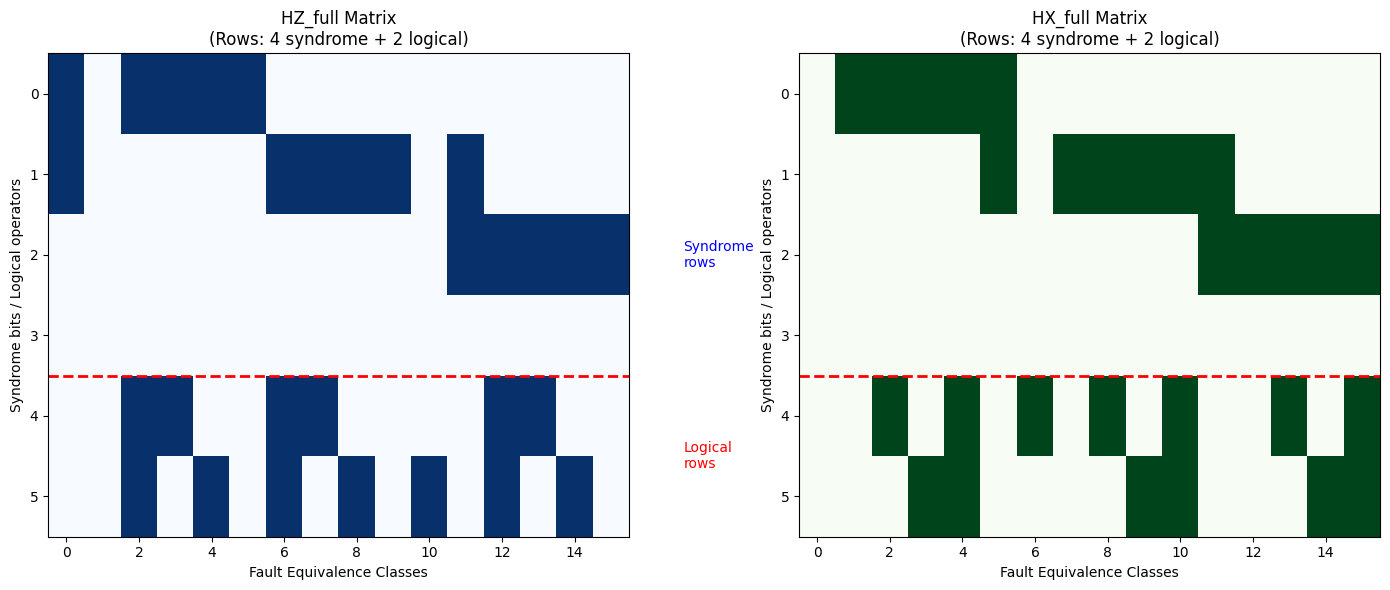


Matrix Interpretation:
  • Each column = one fault equivalence class
  • 1s in syndrome rows = which syndrome bits this fault affects
  • 1s in logical rows = logical effect of this fault
  • Red line separates syndrome (above) from logical (below)


In [95]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
im1 = ax1.imshow(HZ_full, aspect='auto', cmap='Blues', interpolation='nearest')
ax1.axhline(y=num_syndrome_bits_Z - 0.5, color='red', linewidth=2, linestyle='--')
ax1.set_title(f'HZ_full Matrix\n(Rows: {num_syndrome_bits_Z} syndrome + {Lx.shape[0]} logical)', fontsize=12)
ax1.set_xlabel('Fault Equivalence Classes')
ax1.set_ylabel('Syndrome bits / Logical operators')
ax1.text(HZ_full.shape[1] + 1, num_syndrome_bits_Z/2, 'Syndrome\nrows', va='center', fontsize=10, color='blue')
ax1.text(HZ_full.shape[1] + 1, num_syndrome_bits_Z + 0.5, 'Logical\nrows', va='center', fontsize=10, color='red')

ax2 = axes[1]
im2 = ax2.imshow(HX_full, aspect='auto', cmap='Greens', interpolation='nearest')
ax2.axhline(y=num_syndrome_bits_X - 0.5, color='red', linewidth=2, linestyle='--')
ax2.set_title(f'HX_full Matrix\n(Rows: {num_syndrome_bits_X} syndrome + {Lz.shape[0]} logical)', fontsize=12)
ax2.set_xlabel('Fault Equivalence Classes')
ax2.set_ylabel('Syndrome bits / Logical operators')

plt.tight_layout()
plt.show()

print(f"\nMatrix Interpretation:")
print(f"  • Each column = one fault equivalence class")
print(f"  • 1s in syndrome rows = which syndrome bits this fault affects")
print(f"  • 1s in logical rows = logical effect of this fault")
print(f"  • Red line separates syndrome (above) from logical (below)")

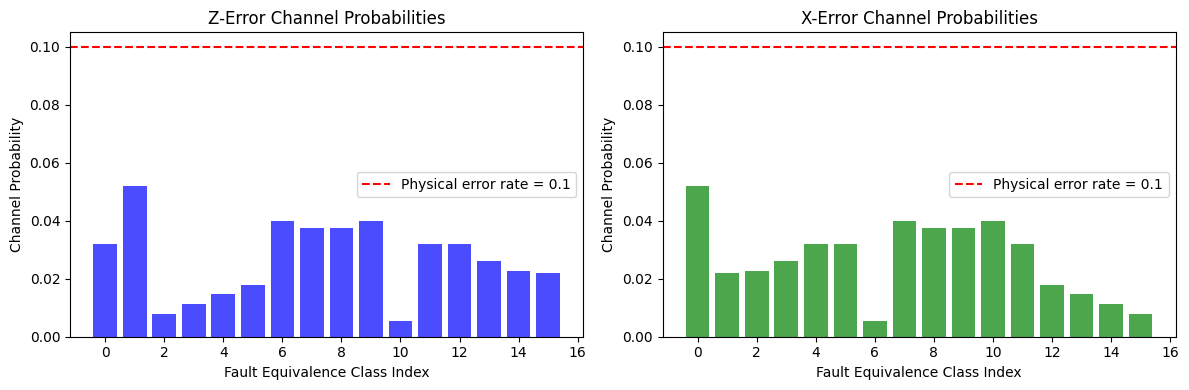


Channel Probability Summary:
  Z-errors: 16 classes, probs in [0.0053, 0.0520]
  X-errors: 16 classes, probs in [0.0053, 0.0520]

  Classes with prob > 0.1:
    Z: 0 (these are merged fault classes)
    X: 0


In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.bar(range(len(channel_probsZ)), channel_probsZ, alpha=0.7, color='blue')
ax1.axhline(y=ERROR_RATE, color='red', linestyle='--', label=f'Physical error rate = {ERROR_RATE}')
ax1.set_xlabel('Fault Equivalence Class Index')
ax1.set_ylabel('Channel Probability')
ax1.set_title('Z-Error Channel Probabilities')
ax1.legend()

ax2 = axes[1]
ax2.bar(range(len(channel_probsX)), channel_probsX, alpha=0.7, color='green')
ax2.axhline(y=ERROR_RATE, color='red', linestyle='--', label=f'Physical error rate = {ERROR_RATE}')
ax2.set_xlabel('Fault Equivalence Class Index')
ax2.set_ylabel('Channel Probability')
ax2.set_title('X-Error Channel Probabilities')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nChannel Probability Summary:")
print(f"  Z-errors: {len(channel_probsZ)} classes, probs in [{channel_probsZ.min():.4f}, {channel_probsZ.max():.4f}]")
print(f"  X-errors: {len(channel_probsX)} classes, probs in [{channel_probsX.min():.4f}, {channel_probsX.max():.4f}]")

higher_than_p_Z = np.sum(channel_probsZ > ERROR_RATE)
higher_than_p_X = np.sum(channel_probsX > ERROR_RATE)
print(f"\n  Classes with prob > {ERROR_RATE}:")
print(f"    Z: {higher_than_p_Z} (these are merged fault classes)")
print(f"    X: {higher_than_p_X}")